In [1]:
%load_ext autoreload

In [3]:
from detectron2.data.datasets.table import register_table_from_dict, write_to_dict, write_to_json
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.engine import DefaultPredictor, DefaultTrainer
import matplotlib.pyplot as plt
from pathlib import Path
import random
import cv2
import os
import matplotlib
import numpy as np

In [205]:
tablebank_metadata = MetadataCatalog.get("invoice_valid")
dataset_dicts = write_to_dict(["/mnt/projects/eai-entity-extraction/datasets/accounting/accounting_20190911/png_samples_from_accounting_20190813/accounting-invoice-table-vendor-8to2-detection-valid-149.json"])

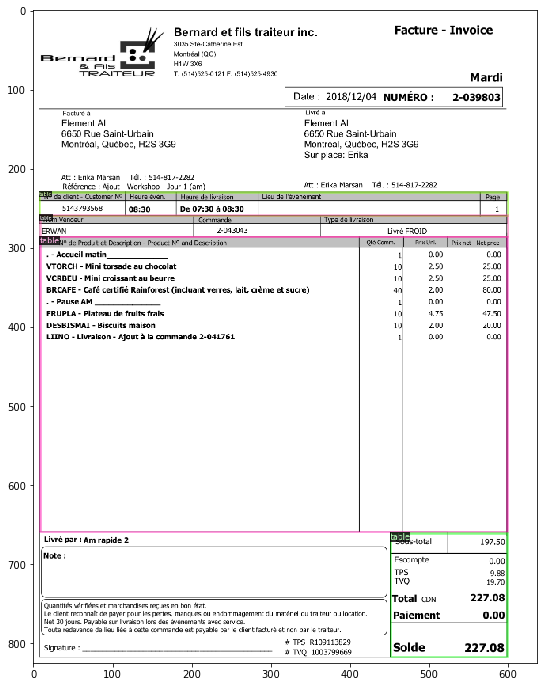

In [255]:
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=tablebank_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    #cv2.imshow("sample", vis.get_image()[:, :, ::-1])
    plt.figure(figsize=(12, 12))
    plt.imshow(vis.get_image()[:, :, ::-1])

**Evaluation**

In [6]:
from detectron2.config import get_cfg
cfg = get_cfg()
cfg.merge_from_file("projects/TableBank/configs/retinanet_R_50_FPN_1x.yaml")

Loading config projects/TableBank/configs/retinanet_R_50_FPN_1x.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.
Config 'projects/TableBank/configs/retinanet_R_50_FPN_1x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


In [7]:
cfg.OUTPUT_DIR = "./projects/TableBank/tablebank_full_3x/"
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "./model_final.pth")

In [8]:
json_path = '/mnt/projects/eai-entity-extraction/datasets/accounting/accounting_20190911/png_samples_from_accounting_20190813/accounting-invoice-table-vendor-8to2-detection-valid-149.json'
dataset_name = 'invoice_valid'
register_table_from_dict([json_path], dataset_name)
tablebank_metadata = MetadataCatalog.get(dataset_name)

In [9]:
cfg.DATASETS.TEST = (dataset_name, )
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.2
predictor = DefaultPredictor(cfg)

In [145]:
img_dir = Path("/mnt/projects/eai-docintel/datasets/invoices/accounting_20190813_png_grouped_by_task")
files = img_dir.glob("**/*.png")

/mnt/projects/eai-docintel/datasets/invoices/accounting_20190813_png_grouped_by_task/tasks/task_20180110 Vasco Electrique/20180110 Vasco Electrique.pdf.png-1.png


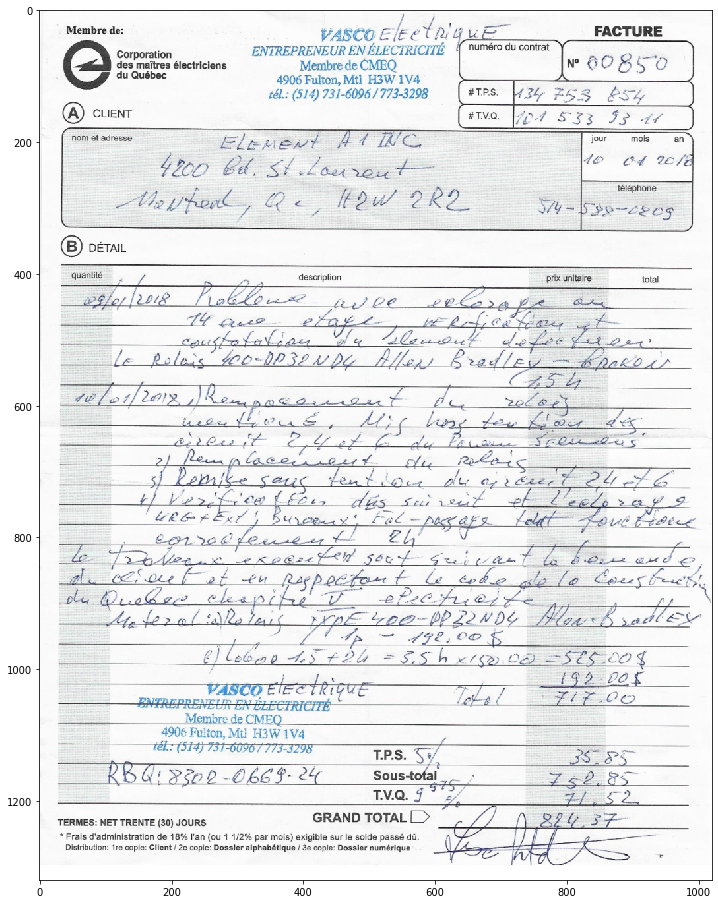

In [202]:
file = next(files)
print(file)
from detectron2.utils.visualizer import ColorMode
dataset_dicts = write_to_dict([json_path])
#for d in random.sample(dataset_dicts, 1):    
#for d in dataset_dicts:
im = cv2.imread(str(file))
outputs = predictor(im)

v = Visualizer(im[:, :, ::-1],
           metadata=tablebank_metadata, 
           scale=0.8, 
           instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels
          )
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(16,16))
plt.imshow(v.get_image()[:, :])

In [672]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator(dataset_name, cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, dataset_name)
inference_on_dataset(predictor.model, val_loader, evaluator)

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.33s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.181
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.307
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.195
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.181
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.190
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.277
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.277
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

OrderedDict([('bbox',
              {'AP': 18.123720572516895,
               'AP50': 30.692349855176715,
               'AP75': 19.46552151365724,
               'APs': 0.0,
               'APm': 0.0,
               'APl': 18.142160350358814})])

In [77]:
def get_bbox_areas(bboxes):
    return np.prod(bboxes[:, 2:4] - bboxes[:, 0:2], axis=1, keepdims=True)


def bbox_intersection_area(bbox0, bbox1):
    int_low = np.maximum(bbox0[:, 0:2], bbox1[:, 0:2])
    int_high = np.minimum(bbox0[:, 2:4], bbox1[:, 2:4])
    # Intersection area
    int_area = np.prod(
        np.maximum(int_high - int_low, int_high * 0), axis=1)
    return int_area


def bbox_intersection_area_matrix(bbox0, bbox1):
    bbox1 = np.swapaxes(bbox1, 0, 1)[None, :, :]
    return bbox_intersection_area(bbox0[:, :, None], bbox1)


def compute_target_prediction_area(prediction, target):
    # get target in np array
    target = np.array([bbox['bbox'] for bbox in target["annotations"]])
    # get prediction in np array
    prediction = prediction["instances"].to("cpu").get("pred_boxes").tensor.numpy()
    # get area matrix, which is of (n_pred, n_gt)
    area_matrix = bbox_intersection_area_matrix(prediction, target)
    # (n_target, 1)
    target_area = get_bbox_areas(target)
    # (n_pred, 1)
    prediction_area = get_bbox_areas(prediction)
    # Gather the detection information
    detections = {
            "area_precision": area_matrix / prediction_area,
            "area_recall": area_matrix / target_area.T,
        }
    #detections = area_matrix / (prediction_area + target_area.T - area_matrix)
    return detections

In [88]:
dataset_dicts = write_to_dict(["/mnt/projects/eai-entity-extraction/datasets/TableBank_data/Detection_data/Word/images/tablebank_word-detection-test-1000.json"])
n_pred, n_gt, sum_precision, sum_recall = 0, 0, 0, 0
for gt in dataset_dicts:
    im = cv2.imread(gt["file_name"])
    prediction = predictor(im)
    #v = Visualizer(im[:, :, ::-1],
    #               metadata=tablebank_metadata, 
    #               scale=0.8, 
    #               instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels
    #              )
    # v = v.draw_instance_predictions
    (outputs["instances"].to("cpu"))
    # plt.figure(figsize=(16,16))
    # plt.imshow(v.get_image()[:, :, ::-1])
    detection_results = compute_target_prediction_area(prediction, gt)
    area_precision = detection_results["area_precision"]
    area_recall = detection_results["area_recall"]
    if area_precision.shape[0] != 0 and area_precision.shape[1] != 0:
        sum_precision += area_precision.max(1).sum()
        sum_recall += area_recall.max(0).sum()
    n_pred += area_precision.shape[0]
    n_gt += area_precision.shape[1]
    
precision = sum_precision / n_pred
recall = sum_recall / n_gt
f1 = 2 * precision * recall / (precision + recall)
print("area precision: ", precision)
print("area recall ", recall)
print("area f1 score", f1)

area precision:  0.8095424009674842
area recall  0.9845420354965426
area f1 score 0.8885072598256903
